[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://github.com/satya-thirumani/Python/blob/master/AV%20WNS%20analytics%20wizard%202019/WNS_analytics_wizard_2019.ipynb)

# AV WNS Analytics Wizard 2019 Hackathon

Analytics Vidhya - Ad Click Prediction Analysis in Python using sklearn package

https://satya-python.blogspot.com/

Jupyter Notebook in Google Colab

In [1]:
# Importing required packages

import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 50)

import seaborn as sns
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,confusion_matrix,roc_curve,auc
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler,MinMaxScaler,PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier

from imblearn.over_sampling import SMOTE, ADASYN, SVMSMOTE
from imblearn.under_sampling import TomekLinks

Using TensorFlow backend.


# Loading Data

In [2]:
# from google.colab import files,drive
# drive.mount('/content/drive')
# %cd /content/drive/My\ Drive/Analytics\ Vidhya/wns-analytics-wizard-2019

In [3]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")
item_data = pd.read_csv("item_data.csv")
view_log = pd.read_csv("view_log.csv")

test_imp_ids = test["impression_id"]

# EDA - Exploratory Data Analysis

In [4]:
# Check number of features and data points in train and test
print("Number of data points in train: %d" % train.shape[0])
print("Number of features in train: %d" % train.shape[1])

print("Number of data points in test: %d" % test.shape[0])
print("Number of features in test: %d" % test.shape[1])

Number of data points in train: 237609
Number of features in train: 7
Number of data points in test: 90675
Number of features in test: 6


In [5]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0


In [6]:
test.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G
0,a9e7126a585a69a32bc7414e9d0c0ada,2018-12-13 07:44:00,44754,127,latest,1
1,caac14a5bf2ba283db7708bb34855760,2018-12-13 07:45:00,29656,44,latest,0
2,13f10ba306a19ce7bec2f3cae507b698,2018-12-13 07:46:00,25234,296,latest,1
3,39c4b4dc0e9701b55a0a4f072008fb3f,2018-12-13 07:47:00,22988,207,latest,1
4,bf5a572cca75f5fc67f4b14e58b11d70,2018-12-13 07:48:00,35431,242,latest,1


In [7]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 237609 entries, 0 to 237608
Data columns (total 7 columns):
impression_id      237609 non-null object
impression_time    237609 non-null object
user_id            237609 non-null int64
app_code           237609 non-null int64
os_version         237609 non-null object
is_4G              237609 non-null int64
is_click           237609 non-null int64
dtypes: int64(4), object(3)
memory usage: 12.7+ MB


In [8]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 90675 entries, 0 to 90674
Data columns (total 6 columns):
impression_id      90675 non-null object
impression_time    90675 non-null object
user_id            90675 non-null int64
app_code           90675 non-null int64
os_version         90675 non-null object
is_4G              90675 non-null int64
dtypes: int64(3), object(3)
memory usage: 4.2+ MB


In [9]:
train['impression_time'] = pd.to_datetime(train['impression_time'])
test['impression_time'] = pd.to_datetime(test['impression_time'])
view_log['server_time'] = pd.to_datetime(view_log['server_time'])

In [10]:
view_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3118622 entries, 0 to 3118621
Data columns (total 5 columns):
server_time    datetime64[ns]
device_type    object
session_id     int64
user_id        int64
item_id        int64
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 119.0+ MB


In [11]:
view_log.head()

,server_time,device_type,session_id,user_id,item_id
0,2018-10-15 08:58:00,android,112333,4557,32970
1,2018-10-15 08:58:00,android,503590,74788,7640
2,2018-10-15 08:58:00,android,573960,23628,128855
3,2018-10-15 08:58:00,android,121691,2430,12774
4,2018-10-15 08:58:00,android,218564,19227,28296


In [12]:
item_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 132761 entries, 0 to 132760
Data columns (total 6 columns):
item_id         132761 non-null int64
item_price      132761 non-null int64
category_1      132761 non-null int64
category_2      132761 non-null int64
category_3      132761 non-null int64
product_type    132761 non-null int64
dtypes: int64(6)
memory usage: 6.1 MB


In [13]:
item_data.head()

,item_id,item_price,category_1,category_2,category_3,product_type
0,26880,4602,11,35,20,3040
1,54939,3513,12,57,85,6822
2,40383,825,17,8,279,1619
3,8777,2355,13,58,189,5264
4,113705,1267,17,39,151,10239


In [14]:
# Checking for NULL/missing values
train.isnull().sum()

impression_id      0
impression_time    0
user_id            0
app_code           0
os_version         0
is_4G              0
is_click           0
dtype: int64

0    226747
1     10862
Name: is_click, dtype: int64
0    95.428624
1     4.571376
Name: is_click, dtype: float64



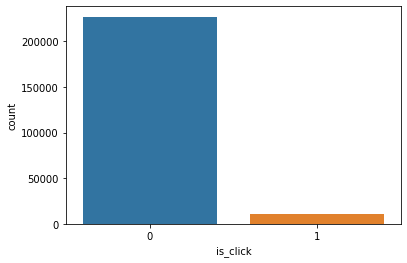

In [15]:
# Univariate analysis
print(train['is_click'].value_counts())
print(train['is_click'].value_counts(normalize=True)*100)
print()
sns.countplot(train["is_click"])

0    151758
1     85851
Name: is_4G, dtype: int64


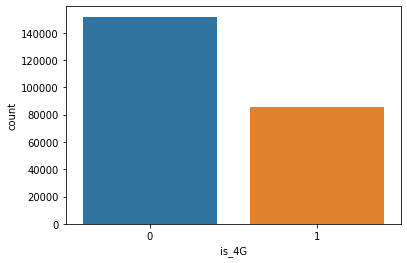

In [16]:
print(train.is_4G.value_counts().sort_index())
sns.countplot(train["is_4G"])

intermediate     55543
latest          129216
old              52850
Name: os_version, dtype: int64


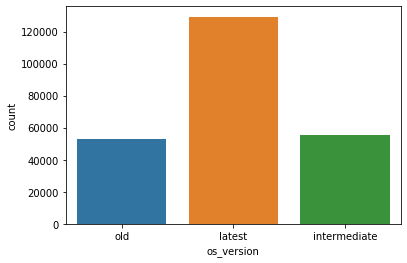

In [17]:
print(train.os_version.value_counts().sort_index())
sns.countplot(train["os_version"])

In [18]:
train.app_code.describe()

count    237609.000000
mean        249.099971
std         135.213609
min           0.000000
25%         163.000000
50%         213.000000
75%         385.000000
max         522.000000
Name: app_code, dtype: float64

In [19]:
train.user_id.describe()

count    237609.000000
mean      46454.526828
std       26802.726666
min           0.000000
25%       23197.000000
50%       46597.000000
75%       69684.000000
max       92586.000000
Name: user_id, dtype: float64

# Preparing Data

In [20]:
view_item_log = pd.merge(view_log, item_data, on='item_id', how='left')
view_item_log.head()

,server_time,device_type,session_id,user_id,item_id,item_price,category_1,category_2,category_3,product_type
0,2018-10-15 08:58:00,android,112333,4557,32970,54685.0,16.0,56.0,253.0,3184.0
1,2018-10-15 08:58:00,android,503590,74788,7640,1376.0,7.0,71.0,228.0,545.0
2,2018-10-15 08:58:00,android,573960,23628,128855,4544.0,4.0,38.0,62.0,5609.0
3,2018-10-15 08:58:00,android,121691,2430,12774,904.0,17.0,39.0,252.0,2740.0
4,2018-10-15 08:58:00,android,218564,19227,28296,2304.0,12.0,57.0,54.0,7422.0


In [21]:
nb_view_hist = view_item_log.groupby('user_id').count()[['session_id']]
nb_view_hist.columns = ['nb_view_hist']
train = pd.merge(train, nb_view_hist, how= 'left', on= 'user_id')
test = pd.merge(test, nb_view_hist, how= 'left', on= 'user_id')

In [22]:
avg_item_price = view_item_log.groupby('user_id').mean()[['item_price']]
avg_item_price.columns = ['avg_item_price']
train = pd.merge(train, avg_item_price, how= 'left', on= 'user_id')
test = pd.merge(test, avg_item_price, how= 'left', on= 'user_id')
train['avg_item_price'] = train['avg_item_price'].fillna(train['avg_item_price'].median())
test['avg_item_price'] = test['avg_item_price'].fillna(test['avg_item_price'].median())

In [23]:
app_ad_cnt = train.groupby('app_code').agg({"is_click": "count"})
app_ad_cnt.rename(columns={"is_click":"ad_count"},inplace=True)
app_ad_cnt['app_code'] = app_ad_cnt.index
app_ad_cnt['ad_pri'] = np.where( (app_ad_cnt['ad_count'] > 2000), 1, 0)
app_ad_cnt.rename(columns={"app_code":"app_code1"},inplace=True)
app_ad_cnt["click_sum"] = train.groupby('app_code').agg({"is_click": "sum"})
app_ad_cnt['ad_click'] = np.where( (app_ad_cnt['click_sum'] > 100), 1, 0)

In [24]:
app_ad_cnt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 490 entries, 0 to 522
Data columns (total 5 columns):
ad_count     490 non-null int64
app_code1    490 non-null int64
ad_pri       490 non-null int64
click_sum    490 non-null int64
ad_click     490 non-null int64
dtypes: int64(5)
memory usage: 23.0 KB


In [25]:
app_ad_cnt.sample(10)

,ad_count,app_code1,ad_pri,click_sum,ad_click
app_code,,,,,
290,53,290,0,2,0
160,3,160,0,0,0
176,71,176,0,12,0
491,437,491,0,16,0
319,643,319,0,16,0
208,1,208,0,0,0
291,192,291,0,10,0
236,6,236,0,0,0
265,1,265,0,0,0


In [26]:
train = pd.merge(train, app_ad_cnt, left_on="app_code", right_on="app_code1", how ='left')
test = pd.merge(test, app_ad_cnt, left_on="app_code", right_on="app_code1", how ='left')

In [27]:
test['ad_count'] = test['ad_count'].fillna(test['ad_count'].median())
test['ad_pri'] = test['ad_pri'].fillna(test['ad_pri'].median())
test['click_sum'] = test['click_sum'].fillna(test['click_sum'].median())
test['ad_click'] = test['ad_click'].fillna(test['ad_click'].median())

In [28]:
train['impression_time_quarter'] = train['impression_time'].dt.quarter
train['impression_time_year'] = train['impression_time'].dt.year
train['impression_time_month'] = train['impression_time'].dt.month
train['impression_time_day'] = train['impression_time'].dt.day
train['impression_time_hour'] = train['impression_time'].dt.hour
train['impression_time_dayofweek'] = train['impression_time'].dt.dayofweek
train['impression_time_weekday'] = train['impression_time'].dt.weekday_name
train['impression_time_is_weekend'] = np.where(train['impression_time'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)

test['impression_time_quarter'] = test['impression_time'].dt.quarter
test['impression_time_year'] = test['impression_time'].dt.year
test['impression_time_month'] = test['impression_time'].dt.month
test['impression_time_day'] = test['impression_time'].dt.day
test['impression_time_hour'] = test['impression_time'].dt.hour
test['impression_time_dayofweek'] = test['impression_time'].dt.dayofweek
test['impression_time_weekday'] = test['impression_time'].dt.weekday_name
test['impression_time_is_weekend'] = np.where(test['impression_time'].dt.dayofweek.isin(['Sunday', 'Saturday']), 1,0)

In [29]:
train.head()

,impression_id,impression_time,user_id,app_code,os_version,is_4G,is_click,nb_view_hist,avg_item_price,ad_count,app_code1,ad_pri,click_sum,ad_click,impression_time_quarter,impression_time_year,impression_time_month,impression_time_day,impression_time_hour,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend
0,c4ca4238a0b923820dcc509a6f75849b,2018-11-15 00:00:00,87862,422,old,0,0,1,2350.000000,395,422,0,58,0,4,2018,11,15,0,3,Thursday,0
1,45c48cce2e2d7fbdea1afc51c7c6ad26,2018-11-15 00:01:00,63410,467,latest,1,1,12,4452.833333,422,467,0,26,0,4,2018,11,15,0,3,Thursday,0
2,70efdf2ec9b086079795c442636b55fb,2018-11-15 00:02:00,71748,259,intermediate,1,0,2,1598.500000,281,259,0,14,0,4,2018,11,15,0,3,Thursday,0
3,8e296a067a37563370ded05f5a3bf3ec,2018-11-15 00:02:00,69209,244,latest,1,0,18,9963.388889,4369,244,1,539,1,4,2018,11,15,0,3,Thursday,0
4,182be0c5cdcd5072bb1864cdee4d3d6e,2018-11-15 00:02:00,62873,473,latest,0,0,46,8618.934783,1235,473,0,62,0,4,2018,11,15,0,3,Thursday,0


In [30]:
# Checking for NULL/missing values
train.isnull().sum()

impression_id                 0
impression_time               0
user_id                       0
app_code                      0
os_version                    0
is_4G                         0
is_click                      0
nb_view_hist                  0
avg_item_price                0
ad_count                      0
app_code1                     0
ad_pri                        0
click_sum                     0
ad_click                      0
impression_time_quarter       0
impression_time_year          0
impression_time_month         0
impression_time_day           0
impression_time_hour          0
impression_time_dayofweek     0
impression_time_weekday       0
impression_time_is_weekend    0
dtype: int64

In [31]:
test.isnull().sum()

impression_id                  0
impression_time                0
user_id                        0
app_code                       0
os_version                     0
is_4G                          0
nb_view_hist                   0
avg_item_price                 0
ad_count                       0
app_code1                     55
ad_pri                         0
click_sum                      0
ad_click                       0
impression_time_quarter        0
impression_time_year           0
impression_time_month          0
impression_time_day            0
impression_time_hour           0
impression_time_dayofweek      0
impression_time_weekday        0
impression_time_is_weekend     0
dtype: int64

In [32]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 237609 entries, 0 to 237608
Data columns (total 22 columns):
impression_id                 237609 non-null object
impression_time               237609 non-null datetime64[ns]
user_id                       237609 non-null int64
app_code                      237609 non-null int64
os_version                    237609 non-null object
is_4G                         237609 non-null int64
is_click                      237609 non-null int64
nb_view_hist                  237609 non-null int64
avg_item_price                237609 non-null float64
ad_count                      237609 non-null int64
app_code1                     237609 non-null int64
ad_pri                        237609 non-null int64
click_sum                     237609 non-null int64
ad_click                      237609 non-null int64
impression_time_quarter       237609 non-null int64
impression_time_year          237609 non-null int64
impression_time_month         237609 non-nul

In [33]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 90675 entries, 0 to 90674
Data columns (total 21 columns):
impression_id                 90675 non-null object
impression_time               90675 non-null datetime64[ns]
user_id                       90675 non-null int64
app_code                      90675 non-null int64
os_version                    90675 non-null object
is_4G                         90675 non-null int64
nb_view_hist                  90675 non-null int64
avg_item_price                90675 non-null float64
ad_count                      90675 non-null float64
app_code1                     90620 non-null float64
ad_pri                        90675 non-null float64
click_sum                     90675 non-null float64
ad_click                      90675 non-null float64
impression_time_quarter       90675 non-null int64
impression_time_year          90675 non-null int64
impression_time_month         90675 non-null int64
impression_time_day           90675 non-null int64
i

In [34]:
train.drop(["impression_id","impression_time","user_id","app_code1"], axis=1, inplace=True)
test.drop(["impression_id","impression_time","user_id","app_code1"], axis=1, inplace=True)

In [35]:
str_cols= train.loc[:, train.dtypes=='object'].columns.tolist()
str_cols

['os_version', 'impression_time_weekday']

In [36]:
train.sample(5)

,app_code,os_version,is_4G,is_click,nb_view_hist,avg_item_price,ad_count,ad_pri,click_sum,ad_click,impression_time_quarter,impression_time_year,impression_time_month,impression_time_day,impression_time_hour,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend
114559,371,latest,1,0,17,4594.705882,9343,1,687,1,4,2018,11,27,22,1,Tuesday,0
181810,129,latest,0,0,15,25906.266667,7050,1,335,1,4,2018,12,4,1,1,Tuesday,0
211021,190,old,0,0,108,6468.518519,17441,1,741,1,4,2018,12,6,20,3,Thursday,0
159550,207,latest,0,0,42,12245.500000,33788,1,482,1,4,2018,12,5,14,2,Wednesday,0
92502,127,latest,1,0,78,8513.269231,10851,1,577,1,4,2018,11,24,19,5,Saturday,0


In [37]:
test.sample(5)

,app_code,os_version,is_4G,nb_view_hist,avg_item_price,ad_count,ad_pri,click_sum,ad_click,impression_time_quarter,impression_time_year,impression_time_month,impression_time_day,impression_time_hour,impression_time_dayofweek,impression_time_weekday,impression_time_is_weekend
8126,135,old,0,70,19826.671429,57.0,0.0,4.0,0.0,4,2018,12,13,19,3,Thursday,0
90151,386,latest,0,29,12071.344828,30706.0,1.0,248.0,1.0,4,2018,12,18,17,1,Tuesday,0
60508,190,old,0,95,6051.042105,17441.0,1.0,741.0,1.0,4,2018,12,16,14,6,Sunday,0
12315,190,latest,1,96,6253.020833,17441.0,1.0,741.0,1.0,4,2018,12,14,16,4,Friday,0
16492,207,latest,0,1,844.000000,33788.0,1.0,482.0,1.0,4,2018,12,13,6,3,Thursday,0


In [38]:
# One Hot Encoding
train = pd.get_dummies(train, columns=str_cols, drop_first=True)
test = pd.get_dummies(test, columns=str_cols, drop_first=True)

In [39]:
train.sample(5)

,app_code,is_4G,is_click,nb_view_hist,avg_item_price,ad_count,ad_pri,click_sum,ad_click,impression_time_quarter,impression_time_year,impression_time_month,impression_time_day,impression_time_hour,impression_time_dayofweek,impression_time_is_weekend,os_version_latest,os_version_old,impression_time_weekday_Monday,impression_time_weekday_Saturday,impression_time_weekday_Sunday,impression_time_weekday_Thursday,impression_time_weekday_Tuesday,impression_time_weekday_Wednesday
155597,151,1,0,17,12474.352941,2176,1,116,1,4,2018,12,4,19,1,0,1,0,0,0,0,0,1,0
107093,129,1,0,42,19463.619048,7050,1,335,1,4,2018,11,27,11,1,0,1,0,0,0,0,0,1,0
35696,386,0,0,29,14581.655172,30706,1,248,1,4,2018,11,17,18,5,0,0,0,0,1,0,0,0,0
154196,296,0,0,62,7062.129032,7453,1,574,1,4,2018,12,4,14,1,0,0,1,0,0,0,0,1,0
66339,463,0,0,3,6336.000000,2463,1,38,0,4,2018,11,26,23,0,0,1,0,1,0,0,0,0,0


In [40]:
# Correlations between Features and Target
# Find all correlations and sort 
correlations_data = train.corr()['is_click'].sort_values()

# most negative correlations
print(correlations_data.head(10))
print()

# most positive correlations
print(correlations_data.tail(10))

ad_count                            -0.100841
ad_pri                              -0.033485
os_version_latest                   -0.021237
ad_click                            -0.009470
impression_time_weekday_Tuesday     -0.006173
impression_time_day                 -0.005490
app_code                            -0.005449
is_4G                               -0.003464
impression_time_weekday_Wednesday   -0.002211
avg_item_price                      -0.001949
Name: is_click, dtype: float64

impression_time_weekday_Sunday      0.004250
impression_time_weekday_Saturday    0.004461
impression_time_dayofweek           0.005079
click_sum                           0.007983
os_version_old                      0.009159
nb_view_hist                        0.046033
is_click                            1.000000
impression_time_quarter                  NaN
impression_time_year                     NaN
impression_time_is_weekend               NaN
Name: is_click, dtype: float64


In [41]:
train2 = train.drop(['is_click'], axis=1)
target = train["is_click"]
print(train['is_click'].value_counts(normalize=True)*100)

0    95.428624
1     4.571376
Name: is_click, dtype: float64


In [42]:
train2 = train2.loc[:, test.columns]

In [43]:
train2.head()

,app_code,is_4G,nb_view_hist,avg_item_price,ad_count,ad_pri,click_sum,ad_click,impression_time_quarter,impression_time_year,impression_time_month,impression_time_day,impression_time_hour,impression_time_dayofweek,impression_time_is_weekend,os_version_latest,os_version_old,impression_time_weekday_Monday,impression_time_weekday_Saturday,impression_time_weekday_Sunday,impression_time_weekday_Thursday,impression_time_weekday_Tuesday,impression_time_weekday_Wednesday
0,422,0,1,2350.000000,395,0,58,0,4,2018,11,15,0,3,0,0,1,0,0,0,1,0,0
1,467,1,12,4452.833333,422,0,26,0,4,2018,11,15,0,3,0,1,0,0,0,0,1,0,0
2,259,1,2,1598.500000,281,0,14,0,4,2018,11,15,0,3,0,0,0,0,0,0,1,0,0
3,244,1,18,9963.388889,4369,1,539,1,4,2018,11,15,0,3,0,1,0,0,0,0,1,0,0
4,473,0,46,8618.934783,1235,0,62,0,4,2018,11,15,0,3,0,1,0,0,0,0,1,0,0


In [44]:
target.head()

0    0
1    1
2    0
3    0
4    0
Name: is_click, dtype: int64

In [45]:
# Using SMOTE for Balancing Data
sm = SMOTE(random_state=2019)

# sm = ADASYN()

# sm = SVMSMOTE(random_state=2019)

train2, target = sm.fit_sample(train2, target.ravel())
print (sum(target==0))
print (sum(target==1))
sum(target==1)

# tl = TomekLinks()
# train2, target = tl.fit_resample(train2, target)

# print (sum(target==0))
# print (sum(target==1))
# sum(target==1)

226747
226747


226747

In [46]:
poly = PolynomialFeatures(degree=2)
train2 = poly.fit_transform(train2)
test = poly.transform(test)
print("train2 shape:", train2.shape)
poly

train2 shape: (453494, 300)


PolynomialFeatures(degree=2, include_bias=True, interaction_only=False,
                   order='C')

In [47]:
pca = PCA(random_state=2019)
#pca = PCA(random_state=2019, n_components=100)
train2 = pca.fit_transform(train2)
test = pca.transform(test)
print("train2 shape:", train2.shape)
pca

train2 shape: (453494, 300)


PCA(copy=True, iterated_power='auto', n_components=None, random_state=2019,
    svd_solver='auto', tol=0.0, whiten=False)

In [48]:
print("\n train2 shape:", train2.shape)
#scaler = StandardScaler()
scaler = MinMaxScaler()
train2 = scaler.fit_transform(train2)
test = scaler.transform(test)

# SMOTE train2 shape: (453494, 16)


 train2 shape: (453494, 300)


In [49]:
test.shape

(90675, 300)

In [50]:
x_train, x_val, y_train, y_val = train_test_split(train2, target, test_size=0.3, random_state=123)
print(x_train.shape, x_val.shape)

(317445, 300) (136049, 300)


In [51]:
x_train

array([[5.49168476e-04, 3.53194376e-01, 2.53332974e-01, ...,
        3.91711079e-01, 6.96827080e-04, 3.89467638e-01],
       [3.96552647e-05, 3.73743730e-01, 2.57624314e-01, ...,
        3.91673547e-01, 6.92706981e-04, 3.89258136e-01],
       [8.47737313e-03, 1.65362342e-01, 1.99430939e-01, ...,
        3.91642461e-01, 6.74730552e-04, 3.89277129e-01],
       ...,
       [4.43843830e-04, 3.59386761e-01, 2.54285766e-01, ...,
        3.91649397e-01, 7.18036876e-04, 3.89374594e-01],
       [5.04339101e-04, 3.59123217e-01, 2.53918194e-01, ...,
        3.91660196e-01, 6.71244806e-04, 3.89345836e-01],
       [2.69392921e-04, 3.77149745e-01, 2.57446706e-01, ...,
        3.91690587e-01, 7.44423257e-04, 3.89262465e-01]])

# Neural Networks / MLP

In [52]:
import itertools

def plot_confusion_matrix(model, normalize=False): # This function prints and plots the confusion matrix.
    cm = confusion_matrix(y_val, model, labels=[0, 1])
    classes=["Will Pay", "Will Default"]
    cmap = plt.cm.Blues
    title = "Confusion Matrix"
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.around(cm, decimals=3)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [53]:
# Receiver Operating Characteristic
sns.set('talk', 'whitegrid', 'dark', font_scale=1, font='Ricty',rc={"lines.linewidth": 2, 'grid.linestyle': '--'})

def plotAUC(truth, pred, lab):
    fpr, tpr, _ = roc_curve(truth,pred)
    roc_auc = auc(fpr, tpr)
    lw = 2
    c = (np.random.rand(), np.random.rand(), np.random.rand())
    plt.plot(fpr, tpr, color= c,lw=lw, label= lab +'(AUC = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")

In [54]:
%timeit
clf_NN = MLPClassifier(activation='tanh', alpha=0.0001, max_iter=500, hidden_layer_sizes=(150, 150, 150), random_state=2019, solver='sgd')
clf_NN.fit(x_train, y_train)
predict_NN = clf_NN.predict(x_val)
predictproba_NN = clf_NN.predict_proba(x_val)[:,1]
predict_NN
y_pred = clf_NN.predict(test)

In [55]:
clf_NN

MLPClassifier(activation='tanh', alpha=0.0001, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=False, epsilon=1e-08,
              hidden_layer_sizes=(150, 150, 150), learning_rate='constant',
              learning_rate_init=0.001, max_iter=500, momentum=0.9,
              n_iter_no_change=10, nesterovs_momentum=True, power_t=0.5,
              random_state=2019, shuffle=True, solver='sgd', tol=0.0001,
              validation_fraction=0.1, verbose=False, warm_start=False)

findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.
findfont: Font family ['Ricty'] not found. Falling back to DejaVu Sans.


0.9423222515417239


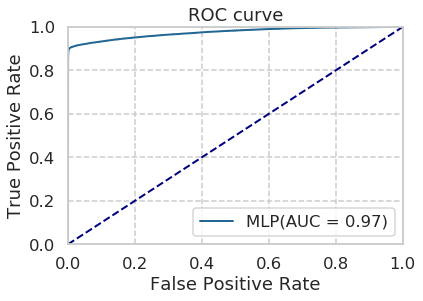

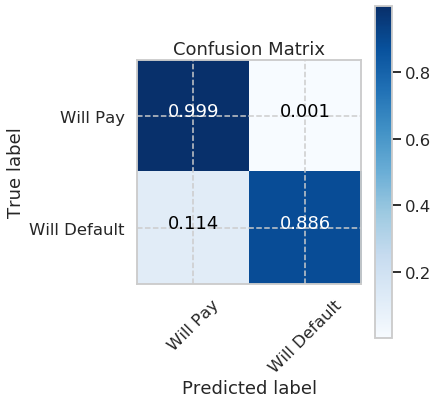

In [56]:
NNAccuracy = accuracy_score(y_val, predict_NN)
print(NNAccuracy)
plotAUC(y_val, predictproba_NN, 'MLP')
plt.show()
plt.figure(figsize=(6,6))
plot_confusion_matrix(predict_NN, normalize=True)
plt.show()

# ROC 0.962
# AUC 0.98

In [57]:
submission = pd.DataFrame(data = {"impression_id":test_imp_ids, "is_click":y_pred})
submission.to_csv("submission.csv", index=False)
print(submission['is_click'].value_counts())

0    90634
1       41
Name: is_click, dtype: int64


In [63]:
!pwd; ls -ltr

/Users/sthirumani/Desktop/Satya/Data Science/Analytics Vidhya/WNS-analytics-wizard-2019
total 349808
-rwxrwxrwx@ 1 sthirumani  staff                3346472 Aug 19 11:33 item_data.csv
-rwxrwxrwx@ 1 sthirumani  staff              146595750 Aug 19 19:12 view_log.csv
-rw-r--r--@ 1 sthirumani  staff                6567193 Aug 20 17:02 test.csv
-rw-r--r--@ 1 sthirumani  staff               17681346 Aug 20 17:02 train.csv
drwxr-xr-x  4 sthirumani  CORP\Domain Users        128 Aug 29 20:02 old
-rw-r--r--@ 1 sthirumani  CORP\Domain Users     118174 Aug 31 10:41 WNS_analytics_wizard_2019_v3.ipynb
-rw-r--r--@ 1 sthirumani  CORP\Domain Users     371055 Aug 31 13:43 WNS_analytics_wizard_2019_v5.ipynb
-rw-r--r--@ 1 sthirumani  CORP\Domain Users    3173648 Sep  1 20:06 submission.csv
-rw-r--r--@ 1 sthirumani  CORP\Domain Users     210660 Sep  1 20:19 WNS_analytics_wizard_2019_v4.ipynb


In [59]:
#files.download('submission.csv')

In [60]:
# parameter_space = {
#     'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
#     'activation': ['tanh', 'relu'],
#     'solver': ['sgd', 'adam'],
#     'alpha': [0.0001, 0.05],
#     'learning_rate': ['constant','adaptive'],
# }
# clf = GridSearchCV(clf_NN, parameter_space, n_jobs=-1, cv=3)

In [61]:
# clf.fit(train2, target)
# Y_pred_test = clf.predict(test)
# Y_pred_test

In [62]:
# clf.best_params_
# # {'activation': 'tanh',
# #  'alpha': 0.0001,
# #  'hidden_layer_sizes': (50, 50, 50),
# #  'learning_rate': 'constant',
# #  'solver': 'sgd'}